<a href="https://colab.research.google.com/github/SRIRAJGURUNATHAN/-INTERFACING-DIGITAL-INPUT-SENSOR-WITH-ARDUINO-PUSH-BUTTON-/blob/main/MINIPEOJECT_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

zip_path = "/content/user+identification+from+walking+activity.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List a few files to confirm
for root, dirs, files in os.walk(extract_path):
    for file in files[:5]:
        print(os.path.join(root, file))


/content/data/__MACOSX/User Identification From Walking Activity/._README
/content/data/__MACOSX/User Identification From Walking Activity/._.DS_Store
/content/data/User Identification From Walking Activity/18.csv
/content/data/User Identification From Walking Activity/13.csv
/content/data/User Identification From Walking Activity/17.csv
/content/data/User Identification From Walking Activity/5.csv
/content/data/User Identification From Walking Activity/6.csv


In [2]:
import glob
import numpy as np
import pandas as pd

# Collect all CSV files
all_files = glob.glob("/content/data/User Identification From Walking Activity/*.csv")

data = []
labels = []

window_size = 100
stride = 50

for i, file in enumerate(all_files):
    try:
        df = pd.read_csv(file, header=None)
        df.columns = ['time', 'x', 'y', 'z']
        df = df[['x', 'y', 'z']].astype('float32')

        if len(df) < window_size:
            continue

        for j in range(0, len(df) - window_size, stride):
            segment = df.iloc[j:j + window_size].values
            data.append(segment)
            labels.append(i)
    except Exception as e:
        print(f"Error reading {file}: {e}")

X = np.array(data)
y = np.array(labels)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


Data shape: (2951, 100, 3), Labels shape: (2951,)


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


X_train: (2360, 100, 3), X_test: (591, 100, 3)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 8, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    x = residual_block(x, 64, 5)
    x = residual_block(x, 64, 5)
    x = residual_block(x, 64, 5)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_resnet(input_shape=(X.shape[1], X.shape[2]), num_classes=y_cat.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │      1,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 100, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │     20,544 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 100, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │     20,544 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 64)   │          0 │ re_lu[0][0],      │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 64)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 100, 64)   │     20,544 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 100, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 64)   │     20,544 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 64)   │          0 │ re_lu_2[0][0],    │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 100, 64)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 100, 64)   │     20,544 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 128,086 (500.34 KB)

 Trainable params: 127,190 (496.84 KB)

 Non-trainable params: 896 (3.50 KB)

In [5]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.3274 - loss: 2.5612 - val_accuracy: 0.2267 - val_loss: 5.5577
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.7205 - loss: 1.0410 - val_accuracy: 0.2458 - val_loss: 5.9305
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.8024 - loss: 0.7552 - val_accuracy: 0.2203 - val_loss: 7.4958
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.8316 - loss: 0.6131 - val_accuracy: 0.3008 - val_loss: 5.2576
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.8619 - loss: 0.5112 - val_accuracy: 0.3220 - val_loss: 4.7850
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.8624 - loss: 0.5051 - val_accuracy: 0.3623 - val_loss: 3.4336
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.8680 - loss: 0.4805 - val_accuracy: 0.4640 - val_loss: 2.4646
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.8747 - loss: 0.4405 - val_accuracy:

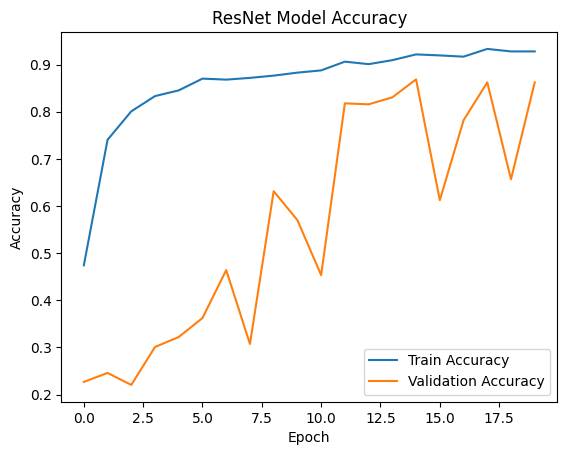

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8596 - loss: 0.4212
Test Accuracy: 84.09%


In [8]:
sample = X_test[0].reshape(1, X.shape[1], X.shape[2])
prediction = model.predict(sample)
predicted_class = np.argmax(prediction)
true_class = np.argmax(y_test[0])

print(f"Predicted Participant ID: {predicted_class}, True ID: {true_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Predicted Participant ID: 2, True ID: 2
